# Model Training Notebook

## 1. Loading the data

In [133]:
# mount drive if working on drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [135]:
# load data nyc_with_osrm_clean.csv
nyc = pd.read_csv('/content/drive/MyDrive/NYC/nyc_with_weather_and_osrm_clean.csv')

<ipython-input-135-db6f322284fa>:2: DtypeWarning: Columns (50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc = pd.read_csv('/content/drive/MyDrive/NYC/nyc_with_weather_and_osrm_clean.csv')


In [136]:
nyc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,low_celsius,mmPrecipitation,mmSnowFall,snowClass,precipitationClass,tempClass,cloudCoverClass,windSpeedClass,pickup_temp_celsius,max_temp_diff
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,...,4.4,7.4,0.0,NaN,Moderate,10-20,Overcast,Calm,8.3,6.2
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,False,...,4.4,7.4,0.0,NaN,Moderate,10-20,Overcast,Calm,10.2,6.2
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,False,...,4.4,7.4,0.0,NaN,Moderate,10-20,Overcast,Calm,9.7,6.2
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,False,...,4.4,7.4,0.0,NaN,Moderate,10-20,Overcast,Calm,6.0,6.2
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,False,...,4.4,7.4,0.0,NaN,Moderate,10-20,Overcast,Calm,10.2,6.2


In [137]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406685 entries, 0 to 1406684
Data columns (total 57 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1406685 non-null  object 
 1   vendor_id                1406685 non-null  int64  
 2   pickup_datetime          1406685 non-null  object 
 3   dropoff_datetime         1406685 non-null  object 
 4   passenger_count          1406685 non-null  int64  
 5   pickup_longitude         1406685 non-null  float64
 6   pickup_latitude          1406685 non-null  float64
 7   dropoff_longitude        1406685 non-null  float64
 8   dropoff_latitude         1406685 non-null  float64
 9   store_and_fwd_flag       1406685 non-null  bool   
 10  trip_duration            1406685 non-null  int64  
 11  pickup_day_of_week       1406685 non-null  object 
 12  dropoff_day_of_week      1406685 non-null  object 
 13  month                    1406685 non-null 

In [138]:
# replace None values with the string 'None'
nyc = nyc.fillna('None')

In [139]:
# drop high_celsius and low_celsius
nyc = nyc.drop(['high_celsius', 'low_celsius'], axis=1)

In [140]:
# drop srcCounty and dstCounty
nyc = nyc.drop(['srcCounty', 'dstCounty'], axis=1)

In [141]:
# add column is_rest_day (forgot to do it before)
nyc['is_rest_day'] = nyc['pickup_day_of_week'].isin(['Saturday', 'Sunday'])

In [142]:
nyc_columns = ['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag']
nyc_eng_columns = [ 'pickup_day_of_week','month','day_of_year','pickup_hour','pickup_hour_in_minutes','hourly_pickup_frequency','daily_pickup_frequency']
distance_columns = ['haversine_distance','manhattan_distance']
numerical_nyc = nyc_columns + nyc_eng_columns + distance_columns
numerical_nyc.remove('month')
numerical_nyc.remove('pickup_day_of_week')

osrm_road_types_columns = ['motorway','trunk','primary','secondary','tertiary','unclassified','residential']
osrm_road_conditions_columns = ['nTrafficSignals','nCrossing','nStop','nIntersection']
osrm_base_columns = ['osrm_distance','osrm_duration']
numerical_osrm = osrm_road_conditions_columns + ['osrm_distance','osrm_duration']
osrm_classes = ['dstCountyClass','srcCountyClass','roadTypeClass']
osrm_columns = osrm_road_types_columns + osrm_road_conditions_columns + osrm_base_columns + osrm_classes

cloud_columns = ['cloudcover (%)','cloudcover_low (%)','cloudcover_mid (%)','cloudcover_high (%)']
wind_columns = ['windspeed']
temp_columns = ['pickup_temp_celsius','max_temp_diff']
precip_columns = ['mmPrecipitation','mmSnowFall']
numerical_weather = wind_columns + cloud_columns + temp_columns + precip_columns
weather_class_columns = ['snowClass','precipitationClass','tempClass','cloudCoverClass','windSpeedClass']

all_numerical = numerical_nyc + numerical_osrm + numerical_weather
all_categorial = osrm_classes + weather_class_columns + ['pickup_day_of_week','month']

features_cols = nyc_columns + ['is_rest_day'] + nyc_eng_columns + distance_columns + osrm_columns + cloud_columns + wind_columns + temp_columns + precip_columns + weather_class_columns

In [143]:
print(len(features_cols))

47


In [144]:
print(features_cols)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'is_rest_day', 'pickup_day_of_week', 'month', 'day_of_year', 'pickup_hour', 'pickup_hour_in_minutes', 'hourly_pickup_frequency', 'daily_pickup_frequency', 'haversine_distance', 'manhattan_distance', 'motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'nTrafficSignals', 'nCrossing', 'nStop', 'nIntersection', 'osrm_distance', 'osrm_duration', 'dstCountyClass', 'srcCountyClass', 'roadTypeClass', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed', 'pickup_temp_celsius', 'max_temp_diff', 'mmPrecipitation', 'mmSnowFall', 'snowClass', 'precipitationClass', 'tempClass', 'cloudCoverClass', 'windSpeedClass']


In [145]:
X = nyc[features_cols]
y = nyc['trip_duration']

## 2. Features selection

In [146]:
def run_experiment(feature_set, all_features, model):
    X_train, X_test, y_train, y_test = preprocess_and_split_data(X, y, feature_set)

    # Train the model on the training data
    y_train_log = np.log1p(y_train)  # Log-transform the target variable
    model.fit(X_train, y_train_log)

    # Make predictions on the test data
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert the predictions back to the original scale
    y_pred = np.clip(y_pred, 0, None)  # Clip negative predictions

    # Evaluate the model using RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

    # Create a dictionary to store results
    result = {feature: (feature in feature_set) for feature in all_features}
    result['RMSLE_TEST'] = rmsle


    y_pred_train = model.predict(X_train)
    y_pred_train = np.expm1(y_pred_train)  # Convert the predictions back to the original scale
    y_pred_train = np.clip(y_pred_train, 0, None)
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    result['RMSLE_TRAIN'] = rmsle_train

    return result

def preprocess_and_split_data(X, y, feature_set,split_ratio=0.2):
    # Split data into training and testing sets
    X_preprocessed = preprocess_data(X[feature_set], feature_set)
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=split_ratio, random_state=42)
    return X_train, X_test, y_train, y_test

def preprocess_data(X, features):
    preprocessor = get_preprocessor(features)
    X = preprocessor.fit_transform(X)
    return X

def get_preprocessor(features):
    features_dict = groupby_feature_type(features)
    categorical_features = features_dict['categorical']
    boolean_features = features_dict['boolean']
    binary_features = features_dict['binary']
    numerical_features = features_dict['numerical']

    # OneHotEncode and scale within a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features),
            ('bool', 'passthrough', boolean_features),
            ('bin', 'passthrough', binary_features),
        ])
    return preprocessor

def groupby_feature_type(features):
    features_dict = {}
    categorical_features = [col for col in features if col in all_categorial]
    boolean_features = [col for col in features if col == 'store_and_fwd_flag' or col == 'is_rest_day']
    binary_features = [col for col in features if col == 'vendor_id']
    numerical_features = [col for col in features if col not in categorical_features + boolean_features + binary_features]

    features_dict['categorical'] = categorical_features
    features_dict['boolean'] = boolean_features
    features_dict['binary'] = binary_features
    features_dict['numerical'] = numerical_features

    return features_dict

Defining features sets that we would like to test, we will various combinations to understand the impact of weather, osrm, and other features on the model performance.

In [147]:
# Define feature sets
feature_sets = {
    'set0': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],
    'set1': ['passenger_count','pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],
    'set2': ['vendor_id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],
    'set3': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour'],
    'set4': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes'],
    'set5': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week'],
    'set6': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year'],
    'set7': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year','hourly_pickup_frequency','daily_pickup_frequency'],
    'set8': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year','hourly_pickup_frequency','daily_pickup_frequency','is_rest_day'],
    'set9': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance'],
    'set10': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'manhattan_distance'],
    'set11': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance','manhattan_distance'],
    'set12': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'osrm_distance'],
    'set13': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance'],
    'set14': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'osrm_duration'],
    'set15': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration'],
    'set16': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection'],
    'set17': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass'],
    'set18': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass','roadTypeClass'],
    'set19': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential'],
    'set20': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass','roadTypeClass','motorway','trunk','primary','secondary','tertiary','unclassified','residential'],
    'set21': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius'],
    'set22': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius', 'max_temp_diff'],
    'set23': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius', 'max_temp_diff','mmPrecipitation'],
    'set24': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius', 'max_temp_diff','mmPrecipitation','mmSnowFall'],
    'set25': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius', 'max_temp_diff','mmPrecipitation','mmSnowFall','windspeed'],
    'set26': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius', 'max_temp_diff','mmPrecipitation','mmSnowFall','windspeed','cloudcover (%)','cloudcover_low (%)','cloudcover_mid (%)','cloudcover_high (%)'],
    'set27': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential', 'max_temp_diff','tempClass','snowClass','precipitationClass','cloudCoverClass','windSpeedClass'],
    'set28': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius', 'max_temp_diff','snowClass','precipitationClass','cloudCoverClass','windSpeedClass'],
    'set29': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential','pickup_temp_celsius', 'max_temp_diff','mmPrecipitation','mmSnowFall','windspeed','cloudcover (%)','cloudcover_low (%)','cloudcover_mid (%)','cloudcover_high (%)','snowClass','precipitationClass','cloudCoverClass','windSpeedClass'],
    'set30': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'haversine_distance','pickup_temp_celsius', 'max_temp_diff','mmPrecipitation','mmSnowFall','windspeed','cloudcover (%)','cloudcover_low (%)','cloudcover_mid (%)','cloudcover_high (%)','snowClass','precipitationClass','cloudCoverClass','windSpeedClass'],
    'set31': features_cols
}

Defining our vanilla model - XGBoost.

In [148]:
models = {
    # 'LinearRegression': LinearRegression(),
    # 'RandomForestRegressor': RandomForestRegressor(random_state=42),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBoostRegressor': XGBRegressor(random_state=42, objective='reg:squarederror', device='cuda')
}

In [149]:
from tqdm import tqdm

def run_batch_experiments(feature_sets, models):
  experiment_results = []
  total_iterations = len(models) * len(feature_sets)

  with tqdm(total=total_iterations, desc="Running experiments") as pbar:
      for model_name, model in models.items():
          for set_name, feature_set in feature_sets.items():
              result = run_experiment(feature_set, features_cols, model)
              result['Experiment'] = set_name
              result['Model'] = model_name
              experiment_results.append(result)
              pbar.update(1)
  results_df = pd.DataFrame(experiment_results)

  cols = ['Experiment', 'Model'] + features_cols + ['RMSLE_TEST', 'RMSLE_TRAIN']
  results_df = results_df[cols]
  return results_df


In [151]:
results_df = run_batch_experiments(feature_sets, models)
results_df

Running experiments: 100%|██████████| 32/32 [02:06<00:00,  3.97s/it]


,Experiment,Model,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_rest_day,...,max_temp_diff,mmPrecipitation,mmSnowFall,snowClass,precipitationClass,tempClass,cloudCoverClass,windSpeedClass,RMSLE_TEST,RMSLE_TRAIN
0,set0,XGBoostRegressor,True,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,0.406052,0.402418
1,set1,XGBoostRegressor,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,0.406256,0.402633
2,set2,XGBoostRegressor,True,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,0.404677,0.401049
3,set3,XGBoostRegressor,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,0.375962,0.372961
4,set4,XGBoostRegressor,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,0.375746,0.372254
5,set5,XGBoostRegressor,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,0.359873,0.356662
6,set6,XGBoostRegressor,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,0.357307,0.354100
7,set7,XGBoostRegressor,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,0.360963,0.357548
8,set8,XGBoostRegressor,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,0.358775,0.355300
9,set9,XGBoostRegressor,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,0.333028,0.326920


In [152]:
features_sets_per_ds = {
    'nyc_original': ['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag'],
    'nyc_with_features_eng': ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year','hourly_pickup_frequency','daily_pickup_frequency','is_rest_day'],
    'nyc_with_osrm':['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' , 'is_rest_day', 'osrm_distance', 'osrm_duration','nTrafficSignals','nCrossing','nStop','nIntersection','dstCountyClass','srcCountyClass', 'motorway','trunk','primary','secondary','tertiary','unclassified','residential'],
    'nyc_with_weather':['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour_in_minutes', 'pickup_day_of_week','month','day_of_year' ,'is_rest_day', 'pickup_temp_celsius', 'max_temp_diff','mmPrecipitation','mmSnowFall','windspeed','cloudcover (%)','cloudcover_low (%)','cloudcover_mid (%)','cloudcover_high (%)'],
    'nyc_with_all': features_cols
}

In [153]:
results_df2 = run_batch_experiments(features_sets_per_ds, models)
results_df2

Running experiments: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


,Experiment,Model,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_rest_day,...,max_temp_diff,mmPrecipitation,mmSnowFall,snowClass,precipitationClass,tempClass,cloudCoverClass,windSpeedClass,RMSLE_TEST,RMSLE_TRAIN
0,nyc_original,XGBoostRegressor,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,0.407266,0.403715
1,nyc_with_features_eng,XGBoostRegressor,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,0.358775,0.355300
2,nyc_with_osrm,XGBoostRegressor,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,0.320576,0.314369
3,nyc_with_weather,XGBoostRegressor,True,True,True,True,True,True,True,True,...,True,True,True,False,False,False,False,False,0.358603,0.354727
4,nyc_with_all,XGBoostRegressor,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,0.315957,0.308769


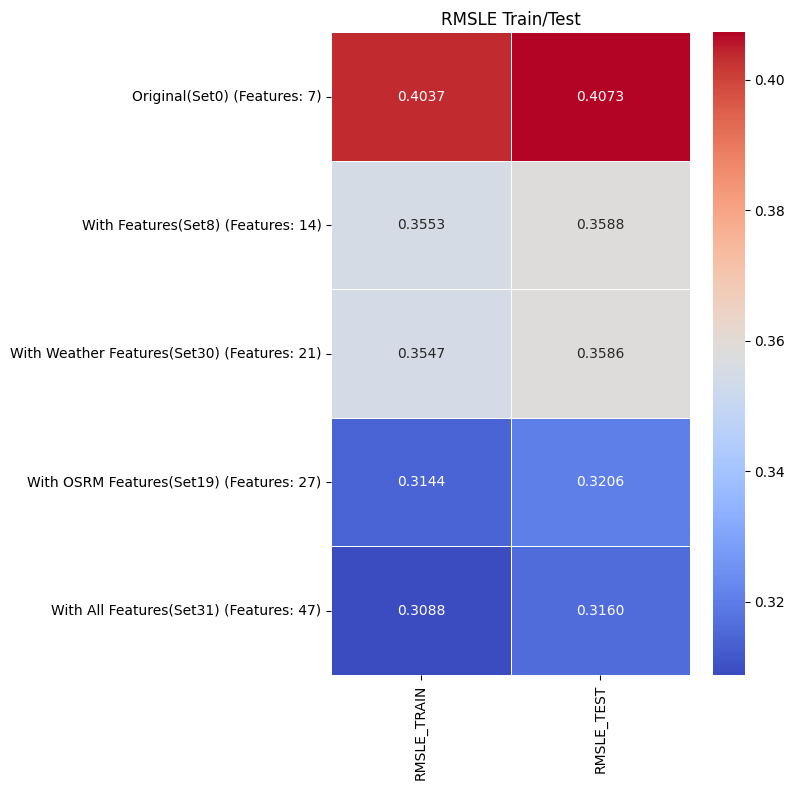

In [154]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

experiments_names = ['Original(Set0)', 'With Features(Set8)', 'With OSRM Features(Set19)', 'With Weather Features(Set30)', 'With All Features(Set31)']

# Add experiment names to the DataFrame
results_df2['Experiment Name'] = experiments_names

# Add number of features to the DataFrame
results_df2['Num of Features'] = results_df2['Experiment'].apply(lambda x: len(features_sets_per_ds[x]))

# Sort by RMSLE_TEST
results_df3 = results_df2.sort_values(by='RMSLE_TEST', ascending=False)

# Extract the RMSLE matrix for heatmap
rmsle_matrix = results_df3[['RMSLE_TRAIN', 'RMSLE_TEST']].astype(float)

# Create the heatmap
plt.figure(figsize=(8, 8))  # Adjust figure size
sns.heatmap(rmsle_matrix, cmap='coolwarm', annot=True, fmt='.4f', linewidths=0.5, cbar=True)

# Add Num of Features as text annotations next to the y-axis labels
experiment_labels = results_df3['Experiment Name'] + ' (Features: ' + results_df3['Num of Features'].astype(str) + ')'

# Set the y-ticks to include the experiment names and the number of features
plt.yticks(ticks=np.arange(len(results_df3.index)) + 0.5, labels=experiment_labels, rotation=0)

# Set x-ticks for RMSLE columns
plt.xticks(ticks=np.arange(len(rmsle_matrix.columns)) + 0.5, labels=rmsle_matrix.columns, rotation=90)

# Set title and adjust layout
plt.title('RMSLE Train/Test')
plt.tight_layout()

# Show the plot
plt.show()


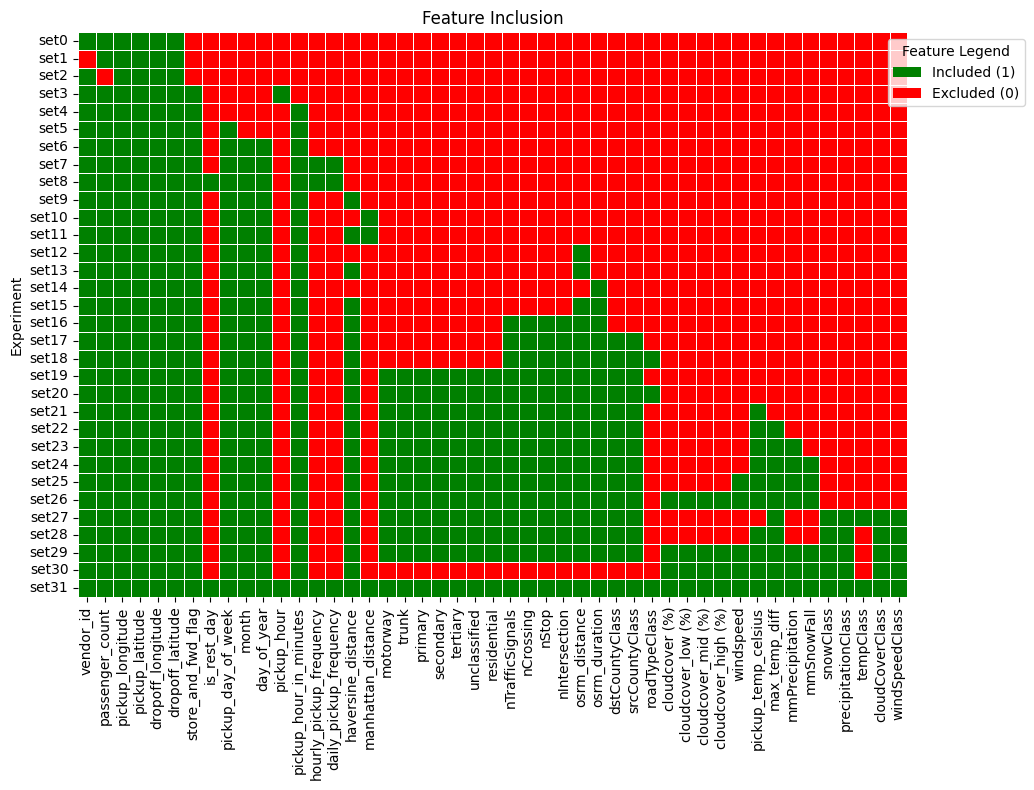

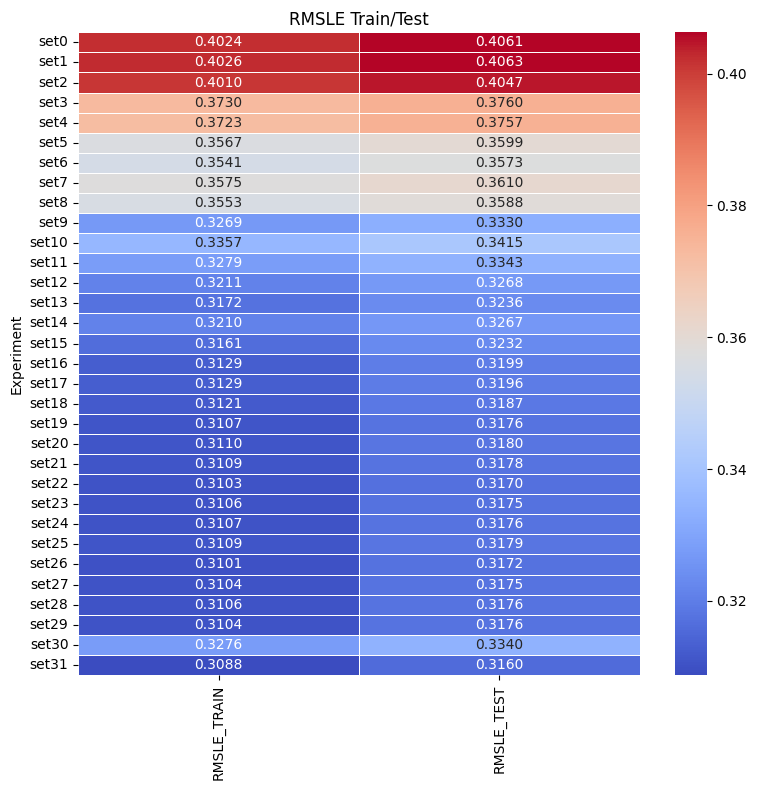

In [155]:
from matplotlib.patches import Patch

def plot_separate_matrices(df, feature_columns, experiment_column='Experiment', model_column='Model'):
    """
    Plots two separate heatmaps: one for feature inclusion and one for Train/Test RMSLE.

    Parameters:
    - df: The DataFrame containing the experiment results, including feature inclusion and RMSLE values.
    - feature_columns: List of columns representing the features in the experiment.
    - experiment_column: The column name for experiments (default is 'Experiment').
    - model_column: The column name for model information to be ignored (default is 'Model').

    The DataFrame is expected to have RMSLE_TRAIN and RMSLE_TEST columns.
    """

    df = df.drop(columns=[model_column], errors='ignore')
    df = df.set_index(experiment_column)

    # Create the two matrices: feature inclusion and RMSLE values
    feature_matrix = df[feature_columns].astype(float)
    rmsle_matrix = df[['RMSLE_TRAIN', 'RMSLE_TEST']].astype(float)

    # First plot: Feature inclusion heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(feature_matrix, cmap=sns.color_palette(["red", "green"]), annot=False,
                linewidths=0.5, cbar=False, square=True)
    plt.title('Feature Inclusion')
    plt.xticks(ticks=np.arange(len(feature_columns)) + 0.5, labels=feature_columns, rotation=90)
    plt.yticks(ticks=np.arange(len(df.index)) + 0.5, labels=df.index, rotation=0)

    legend_elements = [Patch(facecolor='green', label='Included (1)'),
                       Patch(facecolor='red', label='Excluded (0)')]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1), title="Feature Legend")

    plt.tight_layout()
    plt.show()

    # Second plot: RMSLE heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(rmsle_matrix, cmap='coolwarm', annot=True, fmt='.4f', linewidths=0.5, cbar=True)
    plt.title('RMSLE Train/Test')
    plt.xticks(ticks=np.arange(len(rmsle_matrix.columns)) + 0.5, labels=rmsle_matrix.columns, rotation=90)
    plt.yticks(ticks=np.arange(len(df.index)) + 0.5, labels=df.index, rotation=0)
    plt.tight_layout()
    plt.show()

plot_separate_matrices(results_df, features_cols)


## 3. Comparing the performance of different models

In [156]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Log-transform the target variable for training
    y_train_log = np.log1p(y_train)

    # Train the model
    model.fit(X_train, y_train_log)

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)  # Convert the predictions back to the original scale

    # Evaluate the model using RMSLE on test set
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred))

    # Evaluate on the training set
    y_pred_train = model.predict(X_train)
    y_pred_train = np.expm1(y_pred_train)  # Convert the predictions back to the original scale
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))

    return rmsle_train, rmsle_test

# Function to choose and train different models and store results in DataFrame
def run_models(model_name, X_train, X_test, y_train, y_test, best_params=None):
    if model_name == 'xgboost':
        model = XGBRegressor(random_state=42, **best_params, objective='reg:squarederror') if best_params else XGBRegressor(random_state=42)
    elif model_name == 'logistic_regression':
        model = LinearRegression()
    elif model_name == 'decision_tree':
        model = DecisionTreeRegressor(random_state=42)
    elif model_name == 'gradient_boosting':
        model = GradientBoostingRegressor(random_state=42)
    else:
        raise ValueError("Unsupported model type. Choose from 'xgboost', 'logistic_regression', 'decision_tree', 'gradient_boosting'.")

    # Train and evaluate the model
    rmsle_train, rmsle_test = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)

    return pd.DataFrame({
        'Model': [model_name],
        'RMSLE_Train': [rmsle_train],
        'RMSLE_Test': [rmsle_test]
    })

In [157]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'RMSLE_Train', 'RMSLE_Test'])

# Example of how to run the models and store results
X_train, X_test, y_train, y_test = preprocess_and_split_data(X, y, feature_sets['set31'])

# XGBoost with best params
print("Running XGBoost:")
xgboost_result = run_models('xgboost', X_train, X_test, y_train, y_test)
results_df = pd.concat([results_df, xgboost_result], ignore_index=True)

# Logistic Regression (Linear Regression in this case)
print("\nRunning Logistic Regression:")
log_reg_result = run_models('logistic_regression', X_train, X_test, y_train, y_test)
results_df = pd.concat([results_df, log_reg_result], ignore_index=True)

# Decision Tree Regressor
print("\nRunning Decision Tree:")
decision_tree_result = run_models('decision_tree', X_train, X_test, y_train, y_test)
results_df = pd.concat([results_df, decision_tree_result], ignore_index=True)

# Gradient Boosting Regressor
print("\nRunning Gradient Boosting:")
gradient_boosting_result = run_models('gradient_boosting', X_train, X_test, y_train, y_test)
results_df = pd.concat([results_df, gradient_boosting_result], ignore_index=True)

Running XGBoost:


<ipython-input-157-0d5de2eb6c8c>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, xgboost_result], ignore_index=True)



Running Logistic Regression:

Running Decision Tree:

Running Gradient Boosting:


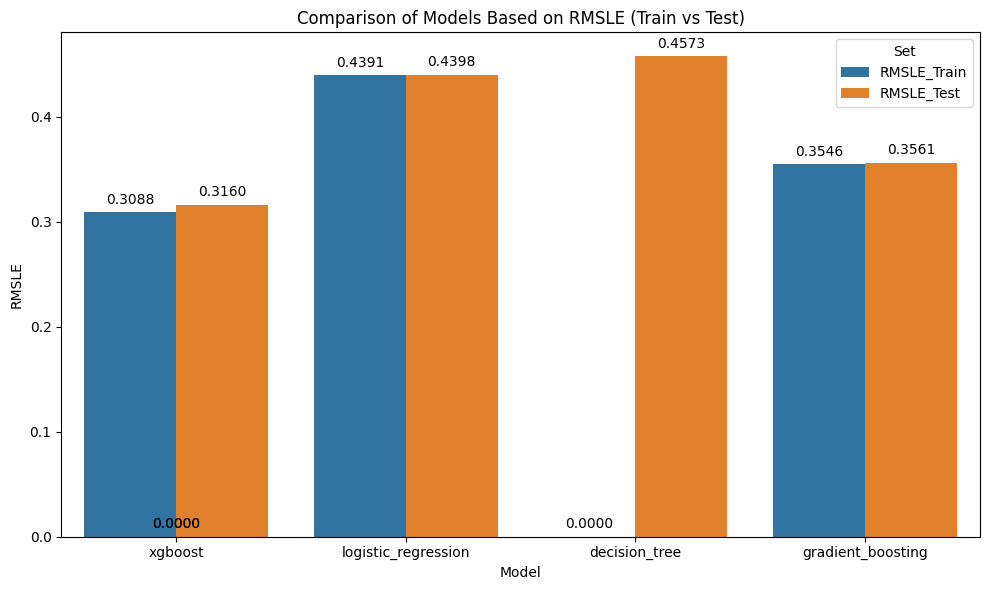

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))

# Reshape the DataFrame for easier plotting
results_melted = pd.melt(results_df, id_vars='Model', value_vars=['RMSLE_Train', 'RMSLE_Test'], var_name='Set', value_name='RMSLE')

# Create a bar plot
ax = sns.barplot(x='Model', y='RMSLE', hue='Set', data=results_melted)

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),  # 9 points vertical offset
                textcoords = 'offset points')

# Add title and labels
plt.title('Comparison of Models Based on RMSLE (Train vs Test)')
plt.ylabel('RMSLE')
plt.xlabel('Model')

# Show the plot
plt.tight_layout()
plt.show()


## 4. Hyperparameter Tuning with RandomizedSearchCV

Since XGBoost performed the best, we will use RandomizedSearchCV to find the best hyperparameters for the XGBoost model.

In [166]:
from sklearn.metrics import make_scorer

def rmsle(y_true_log, y_pred_log):
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_true_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the model
xgb_model = XGBRegressor(random_state=42, device='cuda', objective='reg:squarederror')

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(50, 300, 50),  # 50, 100, 150, 200, 250
    'learning_rate': np.linspace(0.05, 0.3, 60),  # 10 different values between 0.01 and 0.2
    'max_depth': np.arange(3, 10, 1),  # 3, 4, 5, 6, 7, 8, 9
    'min_child_weight': np.arange(1, 7, 2),  # 1, 3, 5
    'subsample': np.linspace(0.6, 1.0, 5),  # 0.6, 0.7, 0.8, 0.9, 1.0
    'colsample_bytree': np.linspace(0.6, 1.0, 5),  # 0.6, 0.7, 0.8, 0.9, 1.0
    'gamma': np.linspace(0, 0.3, 4),  # 0, 0.1, 0.2, 0.3
    'reg_alpha': np.linspace(0, 1.0, 5),  # 0, 0.25, 0.5, 0.75, 1.0
    'reg_lambda': np.linspace(1, 2.5, 4),  # 1, 1.5, 2, 2.5
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=100, scoring=rmsle_scorer,
                                   cv=3, verbose=1, n_jobs=-1, random_state=42)

X_train, X_test, y_train, y_test = preprocess_and_split_data(X, y, feature_sets['set31'])
# Fit the model (make sure X_train and y_train are defined)
y_train_log = np.log1p(y_train)  # Log-transform the target variable
random_search.fit(X_train, y_train_log)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", -random_search.best_score_)


In [160]:
best_params = {'subsample': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 1.0, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.1983050847457627, 'gamma': 0.09999999999999999, 'colsample_bytree': 0.6}
xgb_model = XGBRegressor(random_state=42, **best_params,objective='reg:squarederror')
X_train, X_test, y_train, y_test = preprocess_and_split_data(X, y, feature_sets['set31'])

y_train_log = np.log1p(y_train)
xgb_model.fit(X_train, y_train_log)

y_pred = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred)

rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

y_pred_train = xgb_model.predict(X_train)
y_pred_train = np.expm1(y_pred_train)
rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
print(f'Root Mean Squared Logarithmic Error (RMSLE) on training data: {rmsle_train}')

Root Mean Squared Logarithmic Error (RMSLE): 0.30351403253495796
Root Mean Squared Logarithmic Error (RMSLE) on training data: 0.27604405256452424


Model optimization helped to improve the model performance by 0.013.

## 5. Feature Importance

We will use xgboost feature importance function to understand the importance of each feature in the model.

In [161]:

feature_set = feature_sets['set31']

features_dict = groupby_feature_type(feature_set)
preprocessor = get_preprocessor(feature_set)
X_transformed = preprocessor.fit_transform(X)

# Step 1: Extract the column names for the transformed data
# 1.1 Numerical columns remain the same
numerical_cols = features_dict['numerical']

# 1.2 Extract categorical column names from the OneHotEncoder
ohe = preprocessor.named_transformers_['cat']
categorical_cols = ohe.get_feature_names_out(features_dict['categorical'])

# 1.3 Boolean and binary columns are passed through
boolean_cols = features_dict['boolean']
binary_cols = features_dict['binary']

# Step 2: Combine all column names
all_transformed_columns = list(numerical_cols) + list(categorical_cols) + list(boolean_cols) + list(binary_cols)

# Step 3: Convert the numpy array back into a DataFrame with the correct column names
X_transformed_df = pd.DataFrame(X_transformed, columns=all_transformed_columns)

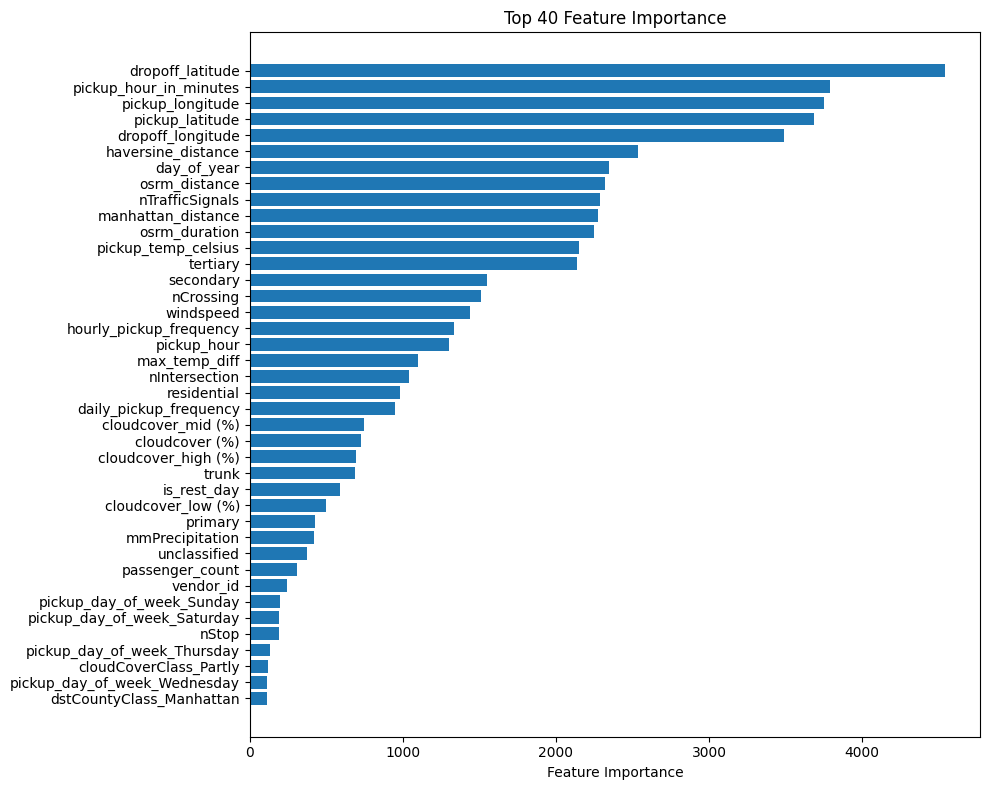

In [162]:

importance_dict = xgb_model.get_booster().get_score(importance_type='weight')
mapped_importance = {X_transformed_df.columns[int(k[1:])]: v for k, v in importance_dict.items()}
sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 8))

top_n = 40
top_features = sorted_importance[:top_n]
top_feature_names, top_feature_importances = zip(*top_features)

plt.barh(top_feature_names, top_feature_importances)
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importance')

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


## 6. Cross-Validation

We will use cross_val_score to evaluate the model using 5-fold cross-validation, to ensure that the model's performance is consistent across different subsets of the data.

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = preprocess_and_split_data(X, y, feature_sets['set31'])
y_train_log = np.log1p(y_train)

cv_scores = cross_val_score(xgb_model, X_train, y_train_log, cv=5, scoring=rmsle_scorer, n_jobs=-1)

# Convert negative RMSLE scores to positive (because `cross_val_score` uses negative scores for loss functions)
rmsle_scores = np.sqrt(-cv_scores)



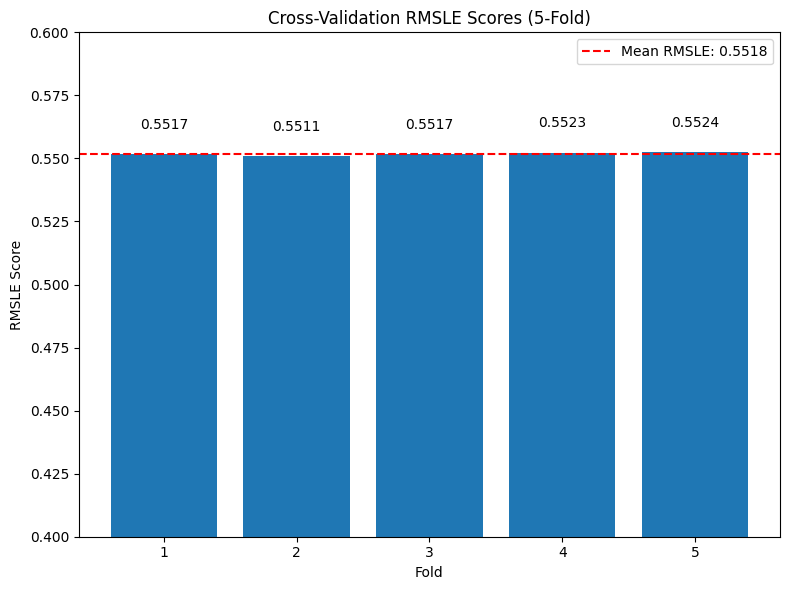

In [164]:

# Plot Cross-Validation RMSLE Scores
plt.figure(figsize=(8, 6))

# Bar plot of RMSLE scores for each fold
plt.bar(range(1, len(rmsle_scores) + 1), rmsle_scores)

# Add a horizontal line showing the mean RMSLE score
mean_rmsle = np.mean(rmsle_scores)
plt.axhline(mean_rmsle, color='red', linestyle='--', label=f'Mean RMSLE: {mean_rmsle:.4f}')

# Annotate each bar with the RMSLE score
for i, score in enumerate(rmsle_scores):
    plt.text(i + 1, score + 0.01, f'{score:.4f}', ha='center', fontsize=10)

# Labels and title
plt.xlabel('Fold')
plt.ylabel('RMSLE Score')
plt.title('Cross-Validation RMSLE Scores (5-Fold)')
plt.ylim(0.4,0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

The model seems to be consistent across different subsets of the data, with the RMSLE scores for each fold being close to the mean RMSLE score.

## 7. Train-Test Split
We will train the xgboost model on different size of train test split to see how it affect the perfomance.

<ipython-input-165-056eb33b34d5>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


   Split Ratio     RMSLE
0          0.1  0.303415
1          0.2  0.303843
2          0.3  0.304144
3          0.4  0.305066


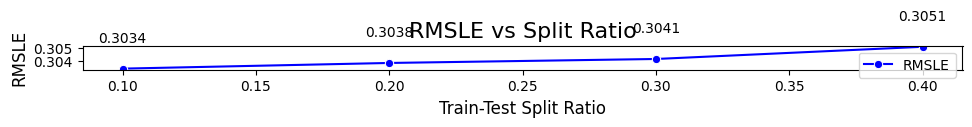

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

# Define the best parameters for XGBoost
best_params = {
    'subsample': 0.9,
    'reg_lambda': 2.0,
    'reg_alpha': 1.0,
    'n_estimators': 150,
    'min_child_weight': 3,
    'max_depth': 9,
    'learning_rate': 0.1983050847457627,
    'gamma': 0.09999999999999999,
    'colsample_bytree': 0.6
}

# Define a function to train and evaluate the model with different split ratios
def train_with_split_ratio(split_ratio, X, y, feature_set, results_df):
    # Split the data using the specified split ratio
    X_train, X_test, y_train, y_test = preprocess_and_split_data(X, y, feature_set, split_ratio=split_ratio)

    # Train the XGBoost model
    xgb_model = XGBRegressor(random_state=42, **best_params, objective='reg:squarederror')
    xgb_model.fit(X_train, np.log1p(y_train))  # Log-transform the target variable for training

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)
    y_pred = np.expm1(y_pred)  # Convert predictions back to the original scale

    # Calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

    # Create a DataFrame for the new result
    new_row = pd.DataFrame({'Split Ratio': [split_ratio], 'RMSLE': [rmsle]})

    # Use pd.concat to add the new result to the results DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return xgb_model, rmsle, results_df

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Split Ratio', 'RMSLE'])

# Define the list of split ratios
split_ratios = [0.1, 0.2, 0.3, 0.4]

# Assume X and y are defined and feature_sets is available
# Run the model with different split ratios
for split_ratio in split_ratios:
    xgb_model, rmsle, results_df = train_with_split_ratio(split_ratio, X, y, feature_sets['set24'], results_df)

# Display the final results
print(results_df)

# Plotting the results
plt.figure(figsize=(10, 6))

# Create a line plot to visualize the RMSLE values across different split ratios
sns.lineplot(x='Split Ratio', y='RMSLE', data=results_df, marker='o', color='b', label='RMSLE')

# Annotate each point with the RMSLE value
for i, row in results_df.iterrows():
    plt.text(row['Split Ratio'], row['RMSLE'] + 0.002, f'{row["RMSLE"]:.4f}', ha='center', fontsize=10)

# Add titles and labels
plt.title('RMSLE vs Split Ratio', fontsize=16)
plt.xlabel('Train-Test Split Ratio', fontsize=12)
plt.ylabel('RMSLE', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


We can see that there is not much difference in the performance of the model with different split ratios.